# Value Extraction and Machine Learning in Spark

**Challenge**:  Predict who will surive the Titanic Disaster.

At times, the only meta-data about a given data source is domain knowledge.  In this case, here is a high-level overview of the configuration of the file. All other information such as source and schema is entirely missing.  In this case, the data is a csv file with the following information available:

**Passenger ID**: Unique ID of that passenger

**Survived**: Whether or not that passenger survived or perished (1 == survived, 0 == did not survive).

**PClass**: Passenger class a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

**Sex**: Gender

**Age** is in Years: Fractional if Age less than One (1) f the Age is Estimated, it is in the form xx.5

**Sibsp**: Number of Siblings/Spouses Aboard

**Parch**: Number of Parents/Children Aboard

**Embarked**: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

#### Load the libraries
You'll notice that there are a lot of libraries loaded for this example.  That is because of the very broad range of functions is needed to cover the entire data pipelining process.  The first block of libraries is for data loading, wrangling, and EDA.  While the second is for machine learning and diagnostics.  After the libraries have been loaded, a Spark Context is created connecting the local instance (driver) to the hypothetical Spark Cluster (executor).

In [1]:
#Load all the libraries
#Spark envrionment and configuration
import getspark #Load environment
from pyspark import SparkContext  #Spark Context Local Driver
from pyspark.sql import SQLContext #SQL Context Local Driver
from pyspark.ml.feature import StringIndexer #Converts strings to indexes
from pyspark.sql.types import * #All Spark SQL data types
from pyspark.sql import Row #Row configurations
from pyspark.sql.functions import col, when, udf

#Machine Learning Libraries
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.classification import SVMWithSGD, SVMModel, LogisticRegressionModel, LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Environment Setup and instantiation
sc = SparkContext() #Load spark context
sqlContext = SQLContext(sc) #Load SQL context

#### Loading the data as a text 'blob'
After loading in the data in as an RDD, we can take a look at it to view some basic attributes.  The first row of the data is in alignment with the metadata descriptions provided, along with seemingly consistent patterns within each follow-up row.  The next step involves splitting the data by its delimiter, which is a perceived to be comma.  Afterwards, the first row containing the header information will need to be removed.  

The following steps involve creating a dataframe object based on the data with the header included.  This dataframe will then be cached into memory because we will be exploring it and iterating over it several times.  

In [3]:
rdd = sc.textFile(r"C:\Spark\train.csv") #Load in the data as a rdd

In [4]:
rdd.take(5) #check out the first five lines of the rdd

[u'PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked',
 u'1,0,3,male,22,1,0,S',
 u'2,1,1,female,38,1,0,C',
 u'3,1,3,female,26,0,0,S',
 u'4,1,1,female,35,1,0,S']

In [5]:
rdd.count() #print out the total number of lines in the rdd

892

In [6]:
#Split it by its delimiter
rdd = rdd.map(lambda line: line.split(",")) #Split it up by comma -transformation

#Strip out the header
header = rdd.first() #Extract header
data = rdd.filter(lambda x:x !=header) #Create a headerless rdd
header #View the header

[u'PassengerId',
 u'Survived',
 u'Pclass',
 u'Sex',
 u'Age',
 u'SibSp',
 u'Parch',
 u'Embarked']

In [7]:
edaframe = sqlContext.createDataFrame(data, header) #create a dataframe from the rdd
edaframe.cache() #cache the dataframe in memory

DataFrame[PassengerId: string, Survived: string, Pclass: string, Sex: string, Age: string, SibSp: string, Parch: string, Embarked: string]

#### Review our data 

The following lines of code perform some basic diagnostics on the dataframe.  We now have visibility as to the schema and formalization of the data.  Now it is up to us to check to make sure our assumptions about the data align with the actual content contain within.  

Note: that the data is import as strings by default.


In [8]:
print "The schema of this data is a follows:"
edaframe.printSchema()
print "Here is a sample of the top five rows:"
edaframe.show(5)
ct = edaframe.count()
print "The total number of rows equals %s" %ct

The schema of this data is a follows:
root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Embarked: string (nullable = true)

Here is a sample of the top five rows:
+-----------+--------+------+------+---+-----+-----+--------+
|PassengerId|Survived|Pclass|   Sex|Age|SibSp|Parch|Embarked|
+-----------+--------+------+------+---+-----+-----+--------+
|          1|       0|     3|  male| 22|    1|    0|       S|
|          2|       1|     1|female| 38|    1|    0|       C|
|          3|       1|     3|female| 26|    0|    0|       S|
|          4|       1|     1|female| 35|    1|    0|       S|
|          5|       0|     3|  male| 35|    0|    0|       S|
+-----------+--------+------+------+---+-----+-----+--------+
only showing top 5 rows

The total number of rows equa

#### View associations by grouping the various data types together
Working with factor level data is very common, the following lines of code further explore the data by performing a series of group-wise comparisons for each column. 

In [9]:
edaframe.groupBy("Survived").count().show()
edaframe.groupBy("Pclass").count().show()
edaframe.groupBy("Sex").count().show()
edaframe.groupBy("Age").count().show()
edaframe.groupBy("SibSp").count().show()
edaframe.groupBy("Parch").count().show()
edaframe.groupBy("Embarked").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       0|  549|
|       1|  342|
+--------+-----+

+------+-----+
|Pclass|count|
+------+-----+
|     1|  216|
|     2|  184|
|     3|  491|
+------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|female|  314|
|  male|  577|
+------+-----+

+----+-----+
| Age|count|
+----+-----+
|70.5|    1|
|36.5|    1|
|  50|   10|
|  51|    7|
|0.75|    2|
|  52|    6|
|  53|    1|
|  54|    8|
|55.5|    1|
|  55|    2|
|  56|    4|
|  57|    2|
|  58|    5|
|40.5|    2|
|  59|    2|
|45.5|    2|
|30.5|    2|
|20.5|    1|
|   1|    7|
|   2|   10|
+----+-----+
only showing top 20 rows

+-----+-----+
|SibSp|count|
+-----+-----+
|    0|  608|
|    1|  209|
|    2|   28|
|    3|   16|
|    4|   18|
|    5|    5|
|    8|    7|
+-----+-----+

+-----+-----+
|Parch|count|
+-----+-----+
|    0|  678|
|    1|  118|
|    2|   80|
|    3|    5|
|    4|    4|
|    5|    5|
|    6|    1|
+-----+-----+

+--------+-----+
|Embarked|count|
+--------+-----+
|

All of the data types appear to be categorical or discrete data factorized as categorical.  The one exception appears to be age, which is assumed to be continuous.  Also worth noting is that the count of blanks on the Embarked column.  This indicates that there are missing values which are not coded as 'null' within the dataframe.  It does not appear this happens on any of the other columns, except for maybe Age.  To understand this better, we will conduct a frequency count of the Age data to check for the pressence of missing or incomplete data.

In [10]:
#Frequency counts by the Age group
freqcount = edaframe.freqItems(['Age'], 0.1).collect()
freqcount[0]

Row(Age_freqItems=[u'28', u'25', u''])

Based on the frequency count analysis, we can see that there are a lot of blank values in the dataframe.  These are represented as a space.  These empty spaces will prevent the data frame from being converted to integers or floats because it is still a string at this point.  We need to find each blank space and replace it with a Null placeholder.  One of the more powerful utilities of Spark is to be able to create UDFs and apply them to the source data.  We will do this in the following example where a new UDF know as 'blank_as_null' will be created to replace all the blank values with a *'None'* placeholder

Recap Note: In Spark dataframes, Null is represented by None.  

In [11]:
#lot of empty strings in age we need to replace them with null values
def blank_as_null(x):
    return when(col(x) != "", col(x)).otherwise(None)

In [12]:
edaframenoempty = edaframe.withColumn("Age", blank_as_null("Age")) #loop over the Age column and replace blanks
edaframenoempty = edaframenoempty.withColumn("Embarked", blank_as_null("Embarked"))  #same with the Embarked column
edaframenoempty.show(10) #Check out the new data frame                                   

+-----------+--------+------+------+----+-----+-----+--------+
|PassengerId|Survived|Pclass|   Sex| Age|SibSp|Parch|Embarked|
+-----------+--------+------+------+----+-----+-----+--------+
|          1|       0|     3|  male|  22|    1|    0|       S|
|          2|       1|     1|female|  38|    1|    0|       C|
|          3|       1|     3|female|  26|    0|    0|       S|
|          4|       1|     1|female|  35|    1|    0|       S|
|          5|       0|     3|  male|  35|    0|    0|       S|
|          6|       0|     3|  male|null|    0|    0|       Q|
|          7|       0|     1|  male|  54|    0|    0|       S|
|          8|       0|     3|  male|   2|    3|    1|       S|
|          9|       1|     3|female|  27|    0|    2|       S|
|         10|       1|     2|female|  14|    1|    0|       C|
+-----------+--------+------+------+----+-----+-----+--------+
only showing top 10 rows



In [13]:
freqcount = edaframenoempty.freqItems(['Age'], 0.1).collect() #Redo the frequency count to make sure that '' is no longer present
freqcount[0]

Row(Age_freqItems=[u'28', u'25', None])

In [14]:
edaframenoempty.count() #Count the dataframe to make sure no data was lost

891

#### Exploratory Data Analysis

Now that the data is in reasonable shape, it is time to begin exporatory data analysis in earnest.  We will begin with some desriptive statistics.  This includes the five number summary and counting the number of Null values in that data set.  We can see that omitting the null values results in a loss of a sizable amount of data.  Given the integrity of these values, then next best step is to impute the missing values to maintain as many observations as possible.  In this example we will use a simple average as the imputed value.

In [15]:
edaframenoempty.na.drop().describe('Age').show() #descriptive statistics, note that you have to drop NAs for this to work

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               712|
|   mean| 29.64209269662921|
| stddev|14.482751702789983|
|    min|              0.42|
|    max|                 9|
+-------+------------------+



In [16]:
edadfimputed = edaframenoempty.na.fill({'Age' : 30})
edadfimputed.count()

891

#### Feature Engineering
To be able to perform mathematical operations and modeling, we need to convert text data into ints or floats.  This borrows heavily from tokenizing practices.  For a simple example, we'll begin by creating another UDF for converting the text identifiers for gender into a boolean value. We will also force a schema of our design onto the dataframe with the Row function.  This will allow us to explicity state the schema, and avoid having to tokenize data types later on.

In [17]:
def genmap(gender):
    if gender == 'female':
        return 1 #female
    else:
        return 0 #Not Female

In [18]:
dfmappd = edadfimputed.map(lambda line: Row(passenger_id = str(line[0]), 
                                    survived = int(line[1]), 
                                    pclass = int(line[2]), 
                                    sex = genmap(line[3]),
                                    age = float(line[4]),
                                    sibsp = int(line[5]),
                                    parch = int(line[6]),
                                    embarked=str(line[7]))).toDF()

In [19]:
#Check out the new dataframe and punch it into memory for QA
print "The schema of this data is a follows:"
dfmappd.printSchema()
print "Here is a sample of the top five rows:"
dfmappd.show(5)
ct = dfmappd.count()
print "The total number of rows equals %s" %ct
dfmappd.cache() #cache the new dataframe

The schema of this data is a follows:
root
 |-- age: double (nullable = true)
 |-- embarked: string (nullable = true)
 |-- parch: long (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- pclass: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- sibsp: long (nullable = true)
 |-- survived: long (nullable = true)

Here is a sample of the top five rows:
+----+--------+-----+------------+------+---+-----+--------+
| age|embarked|parch|passenger_id|pclass|sex|sibsp|survived|
+----+--------+-----+------------+------+---+-----+--------+
|22.0|       S|    0|           1|     3|  0|    1|       0|
|38.0|       C|    0|           2|     1|  1|    1|       1|
|26.0|       S|    0|           3|     3|  1|    0|       1|
|35.0|       S|    0|           4|     1|  1|    1|       1|
|35.0|       S|    0|           5|     3|  0|    0|       0|
+----+--------+-----+------------+------+---+-----+--------+
only showing top 5 rows

The total number of rows equals 891


DataFrame[age: double, embarked: string, parch: bigint, passenger_id: string, pclass: bigint, sex: bigint, sibsp: bigint, survived: bigint]

In [20]:
# categorical/boolean fields can give valuable facets (crosstabs)
dfmappd.crosstab('survived', 'pclass').show()
dfmappd.crosstab('survived', 'embarked').show()
dfmappd.crosstab('survived', 'sex').show()

+---------------+---+---+---+
|survived_pclass|  1|  2|  3|
+---------------+---+---+---+
|              1|136| 87|119|
|              0| 80| 97|372|
+---------------+---+---+---+

+-----------------+---+---+----+---+
|survived_embarked|  Q|  S|None|  C|
+-----------------+---+---+----+---+
|                1| 30|217|   2| 93|
|                0| 47|427|   0| 75|
+-----------------+---+---+----+---+

+------------+---+---+
|survived_sex|  0|  1|
+------------+---+---+
|           1|109|233|
|           0|468| 81|
+------------+---+---+



It would be costly to have to write UDFs for every categorical variable, this also could result in a lot of technological debt, maintanence, and fragility down the line.  Thankfull Spark has numerous tokenizer functions available for us to use.  We'll apply a common one known as StringIndexer to the embarked column to make a new column for the tokenized values.

In [21]:
indexer = StringIndexer(inputCol="embarked", outputCol="embarkerdv")
indexed = indexer.fit(dfmappd).transform(dfmappd)
indexed.show(10)

+----+--------+-----+------------+------+---+-----+--------+----------+
| age|embarked|parch|passenger_id|pclass|sex|sibsp|survived|embarkerdv|
+----+--------+-----+------------+------+---+-----+--------+----------+
|22.0|       S|    0|           1|     3|  0|    1|       0|       0.0|
|38.0|       C|    0|           2|     1|  1|    1|       1|       1.0|
|26.0|       S|    0|           3|     3|  1|    0|       1|       0.0|
|35.0|       S|    0|           4|     1|  1|    1|       1|       0.0|
|35.0|       S|    0|           5|     3|  0|    0|       0|       0.0|
|30.0|       Q|    0|           6|     3|  0|    0|       0|       2.0|
|54.0|       S|    0|           7|     1|  0|    0|       0|       0.0|
| 2.0|       S|    1|           8|     3|  0|    3|       0|       0.0|
|27.0|       S|    2|           9|     3|  1|    0|       1|       0.0|
|14.0|       C|    0|          10|     2|  1|    1|       1|       1.0|
+----+--------+-----+------------+------+---+-----+--------+----

In [22]:
indexed.groupby('embarkerdv').count().show()

+----------+-----+
|embarkerdv|count|
+----------+-----+
|       1.0|  168|
|       3.0|    2|
|       0.0|  644|
|       2.0|   77|
+----------+-----+



In [23]:
indexed.describe('age').show() #Revisiting age

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               891|
|   mean|29.758888888888887|
| stddev|12.995271375176369|
|    min|              0.42|
|    max|              80.0|
+-------+------------------+



With continuous data, it is a good practice to visualize it with a histogram.  This is important to understand the variance and distribution around the data, and if certain assumptions can be maintained.  Spark does not have a native histogram function available for dataframes yet.  We'll have to hack one together by grouping and counting the data and then coercing it into a Pandas dataframe to create the visualization.  Once this is done, we can see that the data follows a normal-ish distribution, with an abundence of values around thirty, which is our imputed value.

In [24]:
def spark_histogram(df, column):
    counts = df.groupby(column).count()
    df = counts.toPandas()
    df[column] = df.age.astype(float) #Specify the column here
    return df.sort_values(column).set_index(column).iloc[:100,:].plot(kind='bar', figsize=(14,5))

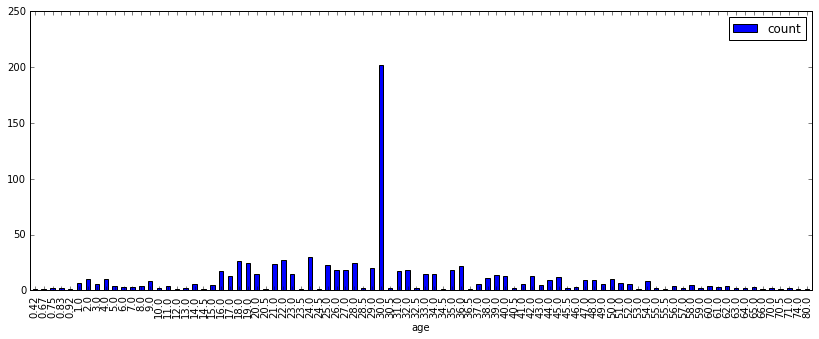

In [25]:
spark_histogram(dfmappd, 'age')

#### Machine Learning with Spark

With EDA and data wrangling out of the way, it is time to begin the machine learning exercise in earnest.  The goals need to be to create a model that predicts the outcome (survival) with a reasonable degree of precision and accuracy.  The model also has to be applied to a new dataframe that can be exported for futher use.  At this time, dataframes cannot be used to create models, word is that this will happen in a future release of Spark.  Until then, we will need to rely on data format called a 'labeledpoint' to conduct modeling.  The label point is a tuple consisting of a response value Y and a series of predictor variables X1..X2..X3..Xn.  Spark has a build in Vector assembler function that will help us with this:

In [26]:
assembler = VectorAssembler(
    inputCols=["age", "parch", "pclass", "sex", "embarkerdv", "sibsp"],
    outputCol="features")

In [27]:
transformed = assembler.transform(indexed)

In [28]:
transformed.show(5) #Not the new features column which is a dense vector of the predictor variables

+----+--------+-----+------------+------+---+-----+--------+----------+--------------------+
| age|embarked|parch|passenger_id|pclass|sex|sibsp|survived|embarkerdv|            features|
+----+--------+-----+------------+------+---+-----+--------+----------+--------------------+
|22.0|       S|    0|           1|     3|  0|    1|       0|       0.0|[22.0,0.0,3.0,0.0...|
|38.0|       C|    0|           2|     1|  1|    1|       1|       1.0|[38.0,0.0,1.0,1.0...|
|26.0|       S|    0|           3|     3|  1|    0|       1|       0.0|[26.0,0.0,3.0,1.0...|
|35.0|       S|    0|           4|     1|  1|    1|       1|       0.0|[35.0,0.0,1.0,1.0...|
|35.0|       S|    0|           5|     3|  0|    0|       0|       0.0|(6,[0,2],[35.0,3.0])|
+----+--------+-----+------------+------+---+-----+--------+----------+--------------------+
only showing top 5 rows



In [29]:
transformed.printSchema() #Confirm the dense vector data type

root
 |-- age: double (nullable = true)
 |-- embarked: string (nullable = true)
 |-- parch: long (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- pclass: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- sibsp: long (nullable = true)
 |-- survived: long (nullable = true)
 |-- embarkerdv: double (nullable = true)
 |-- features: vector (nullable = true)



In [30]:
#Create the labeled point datatype
lpdata = transformed.select(col("survived"), col("features")).map(lambda row: LabeledPoint(row.survived, row.features))

In [31]:
lpdata.take(10)

[LabeledPoint(0.0, [22.0,0.0,3.0,0.0,0.0,1.0]),
 LabeledPoint(1.0, [38.0,0.0,1.0,1.0,1.0,1.0]),
 LabeledPoint(1.0, [26.0,0.0,3.0,1.0,0.0,0.0]),
 LabeledPoint(1.0, [35.0,0.0,1.0,1.0,0.0,1.0]),
 LabeledPoint(0.0, (6,[0,2],[35.0,3.0])),
 LabeledPoint(0.0, [30.0,0.0,3.0,0.0,2.0,0.0]),
 LabeledPoint(0.0, (6,[0,2],[54.0,1.0])),
 LabeledPoint(0.0, [2.0,1.0,3.0,0.0,0.0,3.0]),
 LabeledPoint(1.0, [27.0,2.0,3.0,1.0,0.0,0.0]),
 LabeledPoint(1.0, [14.0,0.0,2.0,1.0,1.0,1.0])]

#### Machine Learning

In the following example, we will use a classic machine learning algorithm called logistic regression.  Logistic regression has been around since the 1950s and works by coercing a series of linear predictors into a sigmoid function against a binary dependent variable.  After the model has been run, we will check for a variety of diagnostics, such as Error Rate and Area under the ROC Curve.

In [32]:
logstmodel = LogisticRegressionWithLBFGS.train(lpdata) #Train the model

In [33]:
logstmodel.weights #AKA coefficients

DenseVector([-0.0059, 0.0038, -0.6247, 2.5438, 0.3116, -0.1849])

In [34]:
# Compute raw scores on the training set
predictionAndLabels = lpdata.map(lambda lp: (float(logstmodel.predict(lp.features)), lp.label))
labelsAndPreds = lpdata.map(lambda p: (p.label, logstmodel.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(lpdata.count())
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Logistic Regression Training Error = " + str(trainErr))
# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Logistic Regression Training Error = 0.204264870932
Area under ROC = 0.772505033074


#### Scoring

Now that we are satified with our model, we need to save the scores for future usage.  This involves mapping the completed model over a collection of features in the dataframe.  Afterwards, the newly completed scores data frame can be saved back to hadoop or exported to a different location.

In [35]:
valuesAndPreds = transformed.map(lambda row: (row.passenger_id, row.survived, float(logstmodel.predict(row.features))))

In [36]:
dfmappd2 = valuesAndPreds.map(lambda line: Row(passenger_id = int(line[0]),
                                               survived = int(line[1]),
                                               score = float(line[2]))).toDF()

In [37]:
pdframe = dfmappd2.toPandas() #ship the predictions to a pandas 

In [38]:
pdframe.head() #Now we can export it, write it to a csv etc.

,passenger_id,score,survived
0,1,0,0
1,2,1,1
2,3,1,1
3,4,1,1
4,5,0,0


#### Manual Scoring Process

Assuming that the model was built in an external process, how can we create scores based on the coefficients of our external model?  This would involve creating a user defined function that passed the scores to a new DataFrame.  

In [39]:
def myLogisticFunc(age, parch, pclass):
    intercept = 3.435222
    betaAge = -0.039841
    betaParch = 0.176439
    betaPclass = -1.239452
    z = intercept + betaAge * age + betaParch * parch + betaPclass * pclass
    return 1.0 / (1.0 + math.exp(-z))
myLogisticFuncUDF = udf(myLogisticFunc)

In [40]:
transformed.withColumn("score", myLogisticFuncUDF(col("age"), col("parch"), col("pclass"))).select("passenger_id", "score").show(10)

+------------+-------------------+
|passenger_id|              score|
+------------+-------------------+
|           1|0.23873343214582232|
|           2|  0.664142996966085|
|           3| 0.2109847155307048|
|           4| 0.6902599781234785|
|           5|0.15741764175944903|
|           6|0.18567465460884552|
|           7| 0.5110871822654997|
|           8| 0.4535401594510565|
|           9|0.26777064098514214|
|          10| 0.5983377902559295|
+------------+-------------------+
only showing top 10 rows

